# Notebook 11_Multimodal Model

## ✅ Step 1: Load & Preprocess Data

In [1]:
import pandas as pd
import numpy as np

# Load energy data
energy_df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
energy_df.set_index('utc_timestamp', inplace=True)

# Load sentiment data
sentiment_df = pd.read_csv('../data/processed/final_sentiment_filtered_news.csv', parse_dates=['date'])
sentiment_df.rename(columns={'date': 'utc_timestamp'}, inplace=True)
sentiment_df['utc_timestamp'] = sentiment_df['utc_timestamp'].dt.floor('h')  # Round to nearest hour
sentiment_df.set_index('utc_timestamp', inplace=True)


# Aggregate hourly sentiment
avg_sentiment = sentiment_df.groupby('utc_timestamp').agg(
    avg_score=('sentiment_score', 'mean'),
    pos_ratio=('sentiment', lambda x: (x == 'POSITIVE').mean()),
    count=('sentiment', 'count')
)
# Keep only numeric columns
numeric_sentiment = avg_sentiment.select_dtypes(include='number')

# Resample to hourly (mean) and forward-fill
sentiment_hourly = numeric_sentiment.resample('h').mean().ffill()

## ✅ Step 2: Merge & Clean

In [2]:
# Merge on timestamp
merged_df = energy_df.merge(sentiment_hourly, left_index=True, right_index=True, how='left')

# Drop if target missing
merged_df = merged_df.dropna(subset=['Price (EUR/MWhe)'])
print(merged_df.columns)

Index(['cet_cest_timestamp', 'DE_load_actual_entsoe_transparency',
       'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'Price (EUR/MWhe)', 'DE_temperature',
       'DE_radiation_direct_horizontal', 'DE_radiation_diffuse_horizontal',
       'Gas_Price', 'Oil_Price', 'avg_score', 'pos_ratio', 'count'],
      dtype='object')


## ✅ Step 3: Feature Engineering

In [3]:
from sklearn.model_selection import train_test_split

# Check which sentiment features were merged successfully
#sentiment_features = [col for col in merged_df.columns if col in ['sentiment_central banks', 'sentiment_europe',
#       'sentiment_impact', 'sentiment_middle east', 'sentiment_science']]
features = [
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal',
    'DE_temperature'
]
features += [
    #'price_lag_24h', 
    #'price_lag_168h',
    'price_lag_336h',
    'price_lag_504h',
    'price_roll_t360_t336',
    'price_roll_t504_t336',
    'price_roll_t672_t336',
    #'price_roll_24h', 
    #'price_roll_168h',
    'hour', 'dayofweek', 'month',
    'solar_load_ratio', 'wind_load_ratio',
    #'avg_score_lag_168h',
    'avg_score_lag_336h',
    'avg_score_lag_504h',
    #'avg_score_t192_t168',
    #'avg_score_t336_t168',
    'avg_score_t360_t336',
    'avg_score_t504_t336',
    'avg_score_t672_t336'
]

# base_features = [
#     'price_lag_24h', 'price_lag_168h',
#     'hour', 'DE_load_actual_entsoe_transparency',
#     'wind_load_ratio', 'solar_load_ratio',
#     'avg_score_lag_24h','avg_score_roll_24h'
# ]
# features = base_features # + sentiment_features

# Add lag and rolling features
merged_df['avg_score_lag_24h'] = merged_df['avg_score'].shift(24)
merged_df['avg_score_lag_168h'] = merged_df['avg_score'].shift(168)
merged_df['avg_score_lag_336h'] = merged_df['avg_score'].shift(336)
merged_df['avg_score_lag_504h'] = merged_df['avg_score'].shift(504)
merged_df['avg_score_roll_24h'] = merged_df['avg_score'].rolling(24).mean()
merged_df['avg_score_roll_168h'] = merged_df['avg_score'].rolling(168).mean()

merged_df['avg_score_t48_t24'] = merged_df['avg_score'].shift(24).rolling(window=24).mean()
merged_df['avg_score_t192_t24'] = merged_df['avg_score'].shift(24).rolling(window=168).mean()
#merged_df['avg_score_roll_336h'] = merged_df['avg_score'].rolling(336).mean()

merged_df['avg_score_t192_t168'] = merged_df['avg_score'].shift(168).rolling(window=24).mean()
merged_df['avg_score_t336_t168'] = merged_df['avg_score'].shift(168).rolling(window=168).mean()
merged_df['avg_score_t360_t336'] = merged_df['avg_score'].shift(336).rolling(window=24).mean()
merged_df['avg_score_t504_t336'] = merged_df['avg_score'].shift(336).rolling(window=168).mean()
merged_df['avg_score_t672_t336'] = merged_df['avg_score'].shift(336).rolling(window=336).mean()

#merged_df['sentiment_central banks_lag_24'] = merged_df['sentiment_central banks'].shift(24)
#merged_df['sentiment_europe_lag_24'] = merged_df['sentiment_europe'].shift(24)
#merged_df['sentiment_impact_lag_24'] = merged_df['sentiment_impact'].shift(24)
#merged_df['sentiment_middle east_lag_24'] = merged_df['sentiment_middle east'].shift(24)
#merged_df['sentiment_science_lag_24'] = merged_df['sentiment_science'].shift(24)

merged_df['price_lag_1h'] = merged_df['Price (EUR/MWhe)'].shift(1)
merged_df['price_lag_24h'] = merged_df['Price (EUR/MWhe)'].shift(24)
merged_df['price_lag_168h'] = merged_df['Price (EUR/MWhe)'].shift(168)
merged_df['price_lag_336h'] = merged_df['Price (EUR/MWhe)'].shift(336)
merged_df['price_lag_504h'] = merged_df['Price (EUR/MWhe)'].shift(504)
merged_df['price_roll_24h'] = merged_df['Price (EUR/MWhe)'].rolling(24).mean()
merged_df['price_roll_168h'] = merged_df['Price (EUR/MWhe)'].rolling(168).mean()

merged_df['price_roll_t192_t168'] = merged_df['Price (EUR/MWhe)'].shift(168).rolling(window=24).mean()
merged_df['price_roll_t336_t168'] = merged_df['Price (EUR/MWhe)'].shift(168).rolling(window=168).mean()
merged_df['price_roll_t360_t336'] = merged_df['Price (EUR/MWhe)'].shift(336).rolling(window=24).mean()
merged_df['price_roll_t504_t336'] = merged_df['Price (EUR/MWhe)'].shift(336).rolling(window=168).mean()
merged_df['price_roll_t672_t336'] = merged_df['Price (EUR/MWhe)'].shift(336).rolling(window=336).mean()

# Calendar and ratio features
merged_df['hour'] = merged_df.index.hour
merged_df['dayofweek'] = merged_df.index.dayofweek
merged_df['month'] = merged_df.index.month
merged_df['solar_load_ratio'] = merged_df['DE_solar_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']
merged_df['wind_load_ratio'] = merged_df['DE_wind_generation_actual'] / merged_df['DE_load_actual_entsoe_transparency']

#merged_df[['sentiment_central banks', 'sentiment_europe','sentiment_impact', 'sentiment_middle east', 'sentiment_science']] = merged_df[['sentiment_central banks', 'sentiment_europe','sentiment_impact', 'sentiment_middle east', 'sentiment_science']].fillna(0)
# Final dataframe
final_df = merged_df[features + ['Price (EUR/MWhe)']].dropna()

# Train-test split
X = final_df[features]
y = final_df['Price (EUR/MWhe)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## ✅ Step 4: Split & Train Model

MAE: 6.64, RMSE: 9.29


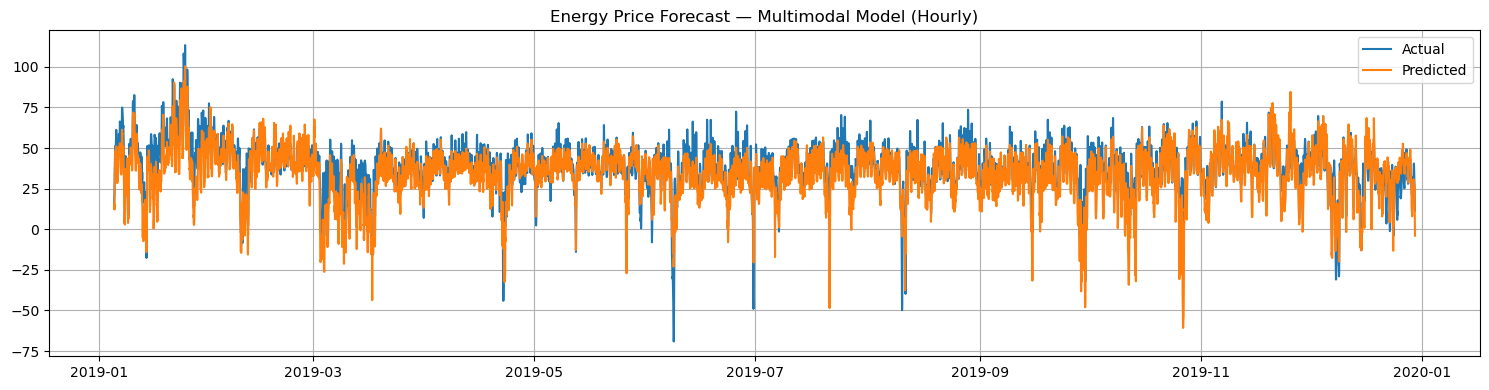

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Train the model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # no squared=False

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Energy Price Forecast — Multimodal Model (Hourly)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Align predictions and actuals to matching index
aligned_index = y_test.index[:len(y_pred)]
y_pred_series = pd.Series(y_pred, index=aligned_index, name="y_pred")
y_test_aligned = y_test.loc[aligned_index]

# Load values aligned to the same index
load_test = final_df.loc[aligned_index, 'DE_load_actual_entsoe_transparency']

# Calculate costs
predicted_total_cost = (y_pred_series * load_test).sum()
actual_total_cost = (y_test_aligned * load_test).sum()

# Print comparison
print(f"💸 Total Predicted Cost: €{predicted_total_cost:,.2f}")
print(f"✅ Total Actual Cost:    €{actual_total_cost:,.2f}")
print(f"📉 Absolute Difference:  €{abs(predicted_total_cost - actual_total_cost):,.2f}")
print(f"📊 Percentage Error:     {100 * abs(predicted_total_cost - actual_total_cost) / actual_total_cost:.2f}%")


💸 Total Predicted Cost: €16,717,258,324.43
✅ Total Actual Cost:    €18,957,649,393.42
📉 Absolute Difference:  €2,240,391,068.99
📊 Percentage Error:     11.82%


pkl file

write to file

In [5]:
import os

# Example variables (replace with actual ones in your notebook)
# y_pred = your model predictions (array-like or Series)
# y_test = actual values (must have datetime index or be aligned)
# model_type = 'U' or 'M'  # Unimodal or Multimodal
# horizon = '24'  # '24', '48', '72', etc.

# Ensure predictions are in a DataFrame with proper datetime index
prediction_df = pd.DataFrame({
    "date": y_test.index,
    "predicted_price": y_pred
})

# Save to /data/results/
output_dir = "data/results"
os.makedirs(output_dir, exist_ok=True)
output_path = f"../data/M_336h.csv"
prediction_df.to_csv(output_path, index=False)

print(f"✅ Saved predictions to {output_path}")


✅ Saved predictions to ../data/M_336h.csv


In [6]:
import joblib

# Assuming your model variable is named `model`
joblib.dump(model, "../saved_models/M336h.pkl")
print("✅ Model saved as M336h.pkl")


✅ Model saved as M336h.pkl


📊 Top Features by Importance:


,Feature,Importance
8,price_lag_336h,0.214332
17,wind_load_ratio,0.210246
16,solar_load_ratio,0.100790
9,price_lag_504h,0.090625
2,DE_load_actual_entsoe_transparency,0.068607
3,Gas_Price,0.048891
15,month,0.043263
12,price_roll_t672_t336,0.033762
4,Oil_Price,0.033249
5,DE_radiation_direct_horizontal,0.019645


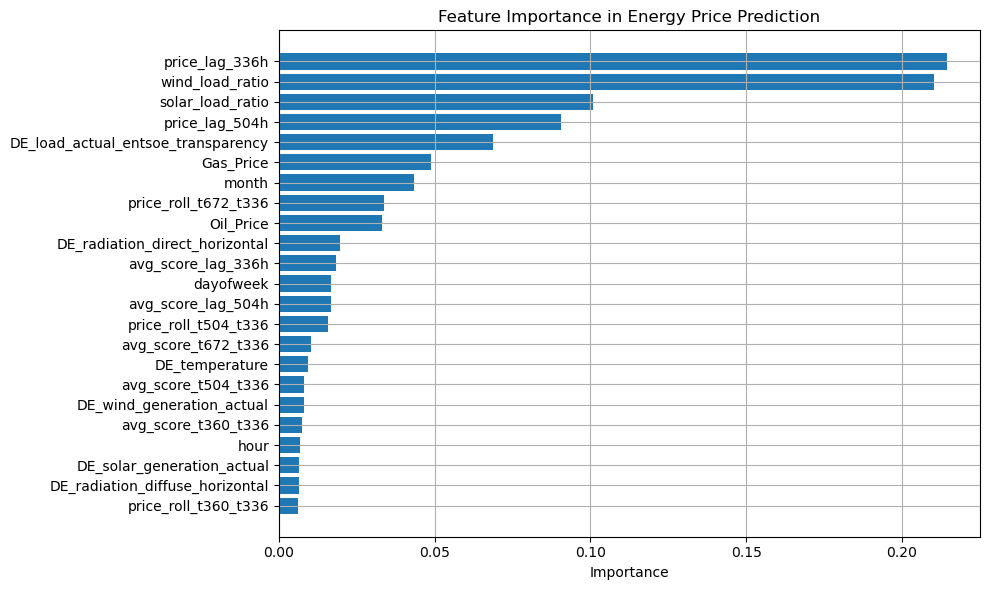

In [7]:
# Extract feature importance after training the model
importances = model.feature_importances_

# If you trained on df_model[features]
feature_names = features  # this is your list of selected input features

# Wrap into DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display
print("📊 Top Features by Importance:")
display(importance_df)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance in Energy Price Prediction")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()
